## Imports

In [ ]:
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify

from sympy import init_printing
init_printing(use_latex=True)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types
#fill the libraries import
#...

In [ ]:
!pip install pyccel==1.1.0

     |████████████████████████████████| 256kB 8.7MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 


## Pure python function

In [ ]:
def solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu):
    #fill the update of u
    #...
  for n in range(nt):
    un[:]=u[:]
    for i in range(1,nx-1):
      u[i]=un[i]-un[i]*dt/dx*(un[i]-un[i-1])+nu*dt/dx**2*(un[i+1]-2*un[i]+un[i-1])
    u[0]=un[0]-un[0]*dt/dx*(un[0]-un[-1])+nu*dt/dx**2*(un[1]-2*un[0]+un[-1])
    u[-1]=u[0]
  return 0

## Numba accelerator

In [ ]:
#add the numba decorator to accelerate code
@njit(fastmath=True)
def solve_1d_burger_numba(u, un, nt, nx, dt, dx, nu):
    #fill the update of u
    #...
  for n in range(nt):
    un[:]=u[:]
    for i in range(1,nx-1):
      u[i]=un[i]-un[i]*dt/dx*(un[i]-un[i-1])+nu*dt/dx**2*(un[i+1]-2*un[i]+un[i-1])
    u[0]=un[0]-un[0]*dt/dx*(un[0]-un[-1])+nu*dt/dx**2*(un[1]-2*un[0]+un[-1])
    u[-1]=u[0]        
    return 0

## Pyccel accelerator

In [ ]:
#add the pyccel decorator to accelerate code
@types('float[:]', 'float[:]','int', 'int', 'float', 'float','float')
def solve_1d_burger_pyccel(u, un, nt, nx, dt, dx, nu):
  for n in range(nt):
    un[:]=u[:]
    for i in range(1,nx-1):
      u[i]=un[i]-un[i]*dt/dx*(un[i]-un[i-1])+nu*dt/dx**2*(un[i+1]-2*un[i]+un[i-1])
    u[0]=un[0]-un[0]*dt/dx*(un[0]-un[-1])+nu*dt/dx**2*(un[1]-2*un[0]+un[-1])
    u[-1]=u[0]
    return 0

## Inputs

In [ ]:
#sympy computation
x, nu, t = sp.symbols('x nu t')
phi = (sp.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sp.exp(-(x - 4 * t - 2 * sp.pi)**2 / (4 * nu * (t + 1))))

phiprime = phi.diff(x)
u = -2 * nu * (phiprime / phi) + 4
ufunc = lambdify((t, x, nu), u)

In [ ]:
###variable declarations
nx = 201
nt = 100
dx = 2 * np.pi / (nx - 1)
nu = .07
dt = dx * nu

x = np.linspace(0, 2 * np.pi, nx)
un = np.empty(nx)
t = 0

## Plot initial condition

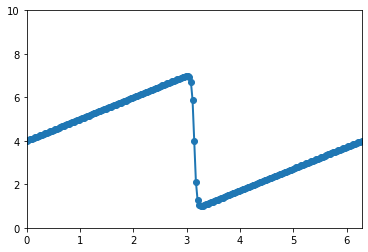

In [ ]:
u = np.asarray([ufunc(t, x0, nu) for x0 in x])
plt.figure()
plt.plot(x, u, marker='o', lw=2)
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10]);

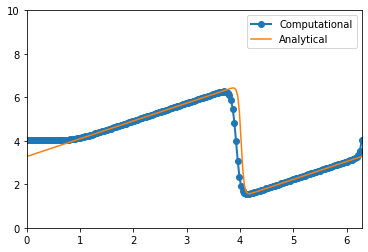

In [ ]:
solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu)

# Analytical solution
u_analytical = np.asarray([ufunc(nt * dt, xi, nu) for xi in x])


#Plotting data
plt.figure()
plt.plot(x,u, marker='o', lw=2, label='Computational')
plt.plot(x, u_analytical, label='Analytical')
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10])
plt.legend();

## Call Funtions

### Pure function

In [ ]:
%timeit solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu)

10 loops, best of 5: 53.3 ms per loop


### Function with numba accelerator

In [ ]:
%timeit solve_1d_burger_numba(u, un, nt, nx, dt, dx, nu)

The slowest run took 428406.72 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 1.39 µs per loop


### Function with pyccel accelerator

In [ ]:
solve_1d_burger_f90 = epyccel(solve_1d_burger_pyccel)
%timeit solve_1d_burger_f90(u, un, nt, nx, dt, dx, nu)

The slowest run took 11.01 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 799 ns per loop
